# CENSORED gamma population model

In [1]:
cd /home/makinen/repositories/fishnets/

/home/makinen/repositories/fishnets


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
#import jax_cosmo as jc
import scipy.constants as cnst
import scipy.stats as ss

import matplotlib.pyplot as plt

import numpy as np
import numpyro
import numpyro.distributions as dist

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.8.4/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
def gamma_pop_model_censored(key, theta, 
                    n_data=500, 
                    serum_min=25., 
                    tmax=10.,
                    A=500.0):

  population = jnp.zeros((n_data, 2))
  mean, scale = theta # shape, reporting delay
  rate = 1./ scale #concentration / report_delay
  concentration = mean / scale
  key,rng = jax.random.split(key)

  def fn(data_tuple):
    data,key = data_tuple
    key,rng = jax.random.split(key)
    decay_time = dist.Gamma(concentration=concentration, 
                           rate=rate).sample(key, ())

    key,rng = jax.random.split(key)
    measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, ())

    key,rng = jax.random.split(key)
    _lambda = A * jnp.exp(-measurement_time / decay_time )
    measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

    #measured_serum_level += dist.Normal(loc=0.0, scale=0.2).sample(key, ())

    return jnp.array([measurement_time, measured_serum_level]), key

  def cond_fun(data_tuple):
    data,_ = data_tuple
    return data[1] < serum_min

  for i in range(population.shape[0]):
      key,rng = jax.random.split(key)
      #ody_fn = lambda d: fn(key=key, data=d)
      data,_ = jax.lax.while_loop(cond_fun, fn, init_val=(jnp.ones((2,))*0, key))

      population = population.at[i, :].set(data)

  return population

In [4]:
# now generate a shitton of simulations over a prior for theta

n_sims = 100000

# theta = (concentration, rate)
# mean of Gamma = concentration / rate
key = jax.random.PRNGKey(33)
mean = dist.Uniform(low=0.5, high=10.).sample(key, (n_sims,))
key,rng = jax.random.split(key)
scale = dist.Uniform(low=0.1, high=1.5).sample(key, (n_sims,))


theta = jnp.vstack([mean, scale]).T

In [5]:
# # now make sims
keys = jax.random.split(jax.random.PRNGKey(0), num=n_sims)
%time data = jax.vmap(gamma_pop_model_censored)(keys, theta)

CPU times: user 1min 5s, sys: 2.59 s, total: 1min 8s
Wall time: 1min 1s


In [6]:
np.save('./gamma_pop/data_gamma_censored.npy', data)
np.save('./gamma_pop/theta_gamma_censored.npy', theta)

In [12]:
# # now make sims
keys = jax.random.split(jax.random.PRNGKey(0), num=n_sims)
%time data = jax.vmap(gamma_pop_model_censored)(keys, theta)

np.save('./gamma_pop/data_gamma_censored.npy', data)
np.save('./gamma_pop/theta_gamma_censored.npy', theta)

CPU times: user 5min 6s, sys: 1.19 s, total: 5min 7s
Wall time: 5min 3s


In [8]:
np.min(data[:, :, 1])

DeviceArray(25., dtype=float32)

In [10]:
np.save('/data80/makinen/fishnets/gamma_pop/data/data_gamma_censored.npy', data)
np.save('/data80/makinen/fishnets/gamma_pop/data/theta_gamma_censored.npy', theta)

# fishnets models

In [4]:
n_sims = 100000

data = np.load('/data80/makinen/fishnets/gamma_pop/data/data_gamma_censored.npy')
theta = np.load('/data80/makinen/fishnets/gamma_pop/data/theta_gamma_censored.npy')

In [5]:
n_sims = 100000
n_data = 500
n_theta = 2

datamax = 500. #np.max(data[:, :, 1])
datamin = 25. #np.min(data[:, :, 1])
tmax = 10.

full_data = np.zeros((n_sims,n_data,n_theta))
full_data[:, :, 0] = data[:, :, 0] / tmax
full_data[:, :, 1] = data[:, :, 1] / datamax
data = full_data; del full_data

In [6]:
import numpy as np

n_sims = 100000
n_data = 500
n_theta = 2

tmax=10. # days
serum_max_val=4.0

theta_fid = tf.constant([5.0, 0.8], dtype=tf.float32) 
theta_fid_ = theta_fid.numpy()

# stack up the data and parameters
data = tf.convert_to_tensor(data, dtype=tf.float32)
theta = tf.convert_to_tensor(theta, dtype=tf.float32)

# construct masks
score_mask = np.ones((n_sims, n_data, n_theta))
fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))


score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

In [7]:
Model = FishnetTwin(n_parameters=n_theta, 
                n_inputs=2, 
                n_hidden_score=[256, 256, 256], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[256, 256, 256], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32))

In [8]:
Model.train((data, theta, score_mask, fisher_mask), lr=1e-3, epochs=100, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=5e-4, epochs=100, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=1e-4, epochs=200, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=5e-5, epochs=200, lossfn='kl')

 79%|███████▉  | 79/100 [32:13<08:33, 24.47s/it, loss=-2.72]


KeyboardInterrupt: 

In [ ]:
Model.train((data, theta, score_mask, fisher_mask), lr=5e-5, epochs=300, lossfn='kl')

In [9]:
# model MLEs
mle, F  = Model.compute_mle_(data[:10000], score_mask[:10000], fisher_mask[:10000])

100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


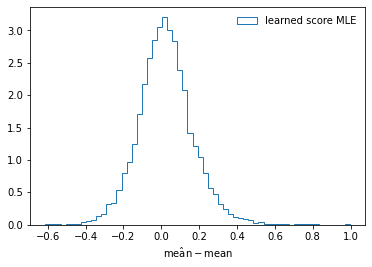

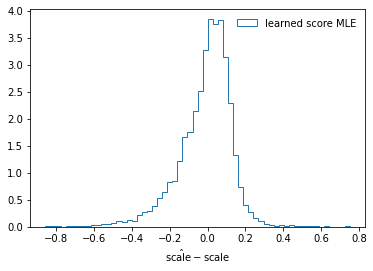

In [13]:
#plt.hist(mle_flow[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,0].numpy() - theta[:10000,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm mean} - \rm{mean}$')
plt.legend(frameon=False)
plt.show()


#plt.hist(mle_flow[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:10000,1].numpy() - theta[:10000,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm scale} - \rm scale$')
plt.legend(frameon=False)
plt.show()

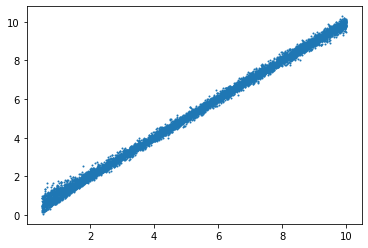

In [14]:
plt.scatter(theta[:10000, 0].numpy(), mle[:10000, 0].numpy(), s=1)

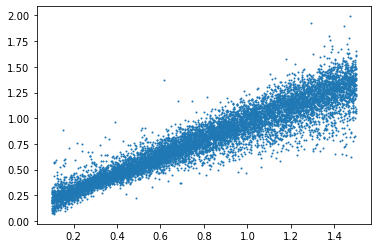

In [15]:
plt.scatter(theta[:10000, 1].numpy(), mle[:10000, 1].numpy(), s=1)

In [41]:
np.std(theta[:10000, 0].numpy()), np.std(mle[:10000,0].numpy() - theta[:10000,0].numpy())

(2.729305, 0.11074221940520282)

In [42]:
np.std(theta[:10000, 1]), np.std(mle[:10000,1].numpy() - theta[:10000,1].numpy())

(0.4017106, 0.10501746343159045)

(array([ 21.,  57., 125., 186., 214., 196., 202., 241., 179., 226., 210.,
        207., 217., 208., 196., 211., 216., 204., 177., 204., 221., 230.,
        208., 225., 199., 232., 200., 230., 204., 199., 224., 193., 214.,
        211., 201., 203., 219., 188., 213., 214., 207., 201., 200., 190.,
        189., 191., 186., 165., 132., 112.,  78.,  65.,  66.,  30.,  20.,
         20.,  10.,   7.,   4.,   2.]),
 array([0.4523078 , 0.47324708, 0.4941864 , 0.5151257 , 0.536065  ,
        0.5570043 , 0.5779436 , 0.5988829 , 0.6198222 , 0.6407615 ,
        0.6617008 , 0.6826401 , 0.7035794 , 0.7245187 , 0.745458  ,
        0.7663973 , 0.7873366 , 0.8082759 , 0.8292152 , 0.8501545 ,
        0.8710938 , 0.8920331 , 0.9129724 , 0.93391174, 0.95485103,
        0.9757903 , 0.9967296 , 1.017669  , 1.0386082 , 1.0595475 ,
        1.0804868 , 1.1014261 , 1.1223655 , 1.1433047 , 1.164244  ,
        1.1851833 , 1.2061226 , 1.2270619 , 1.2480012 , 1.2689406 ,
        1.2898798 , 1.3108191 , 1.3317584 , 1.

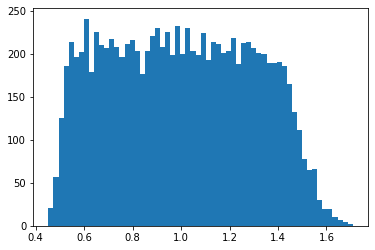

In [17]:
plt.hist(theta[:, 0].numpy() / theta[:, 1].numpy(), bins=60)

In [ ]:

key = jax.random.PRNGKey(88)

concentration = 2.0
rate = 20.
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))

key,rng = jax.random.split(key)
measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, (10000,))

key,rng = jax.random.split(key)
_lambda = A * jnp.exp(-measurement_time / decay_time )
measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

In [ ]:
np.linspace(1, 10)

In [ ]:
rate

In [ ]:
concentration = 4.0
report_delay = 3 # days
rate = concentration / report_delay
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))
plt.hist(np.array(decay_time), bins=60)


# concentration = 2.0
# rate = 2.0 / 10

# decay_time = dist.Gamma(concentration=concentration, 
#                         rate=rate).sample(key, (10000,))
# plt.hist(np.array(decay_time), bins=60)

In [ ]:
plt.hist(np.array(decay_time), bins=60)

In [13]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [15]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))

In [16]:
maf.distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

AttributeError: can't set attribute

In [17]:
maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

In [26]:
F.shape

TensorShape([10000, 2, 2])

In [66]:
mydist = tfd.Sample(
        tfd.MultivariateNormalFullCovariance(loc=0., 
        covariance_matrix=F[:]), sample_shape=[])

In [67]:
mydist.sample().numpy().shape

(10000, 2)

(array([[ 2.,  8.,  7., 22., 17., 18., 16.,  7.,  2.,  1.],
        [ 0.,  0.,  1., 18., 47., 30.,  4.,  0.,  0.,  0.]]),
 array([-24.42128302, -19.23787973, -14.05447645,  -8.87107316,
         -3.68766988,   1.4957334 ,   6.67913669,  11.86253997,
         17.04594326,  22.22934654,  27.41274983]),
 <a list of 2 BarContainer objects>)

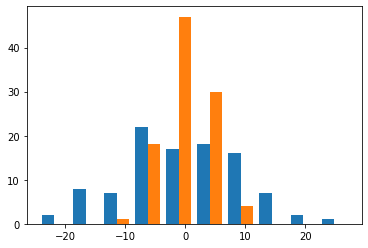

In [60]:
plt.hist(mydist.sample((100,)).numpy()[:, 0])

(array([ 2.,  2.,  4.,  9., 10.,  7.,  4.,  3.,  7.,  2.]),
 array([-1.1977313 , -0.96494275, -0.73215425, -0.49936578, -0.2665773 ,
        -0.0337888 ,  0.19899969,  0.43178818,  0.66457665,  0.89736515,
         1.1301537 ], dtype=float32),
 <BarContainer object of 10 artists>)

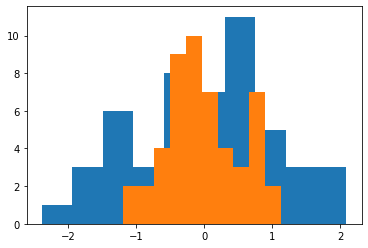

In [25]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))


plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])


maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=0.5), sample_shape=[2])
plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])